## PLINK GWAS Regression Tutorial

These commands walk through running the GWAS regressions from Marees et al. 2018 using PLINK.

As in all PLINK tutorials, the comments and code from the original tutorial are included with R steps commented out (and replaced by python where necessary) and to disambiguate between comments from the original authors and me, the ```#*#``` character is used.

In [1]:
import os.path as osp
import pandas as pd
import numpy as np
import plotnine as pn
from IPython.display import display, Image
%run ../init/benchmark.py
register_timeop_magic(get_ipython(), 'plink')
prev_dir = osp.expanduser('~/data/gwas/tutorial/2_PS_GWAS')
data_dir = osp.expanduser('~/data/gwas/tutorial/3_AA_GWAS')
data_dir

'/home/eczech/data/gwas/tutorial/3_AA_GWAS'

Copy necessary data from directory for second step in tutorial (population stratification) to directory for this step:

In [3]:
%%timeop -o ps0
%%bash -s "$prev_dir" "$data_dir"
set -e
echo "$1 $2"
cp $1/HapMap_3_r3_13.* $2/
cp $1/covar_mds.txt $2/

/home/eczech/data/gwas/tutorial/2_PS_GWAS /home/eczech/data/gwas/tutorial/3_AA_GWAS
Elapsed time: 0.1 seconds


### Step 1: Association Analysis via Hypothesis Testing

Run chi-square tests for each variant testing whether or not independence between the frequency of cases and controls is unlikely for dominant and recessive alleles (as well as several others, all as separate tests). See [PLINK#assoc](https://www.cog-genomics.org/plink/1.9/assoc) for more details.

In [10]:
%%timeop -o aa1
%%bash -s "$data_dir"
set -e; cd $1
# assoc
plink --bfile HapMap_3_r3_13 --assoc --out assoc_results
# Note, the --assoc option does not allow to correct covariates such as principal components (PC's)/ MDS components, which makes it 
# less suited for association analyses.
printf '=%.0s' {1..80}; echo # HR
echo "head assoc_results.assoc"
head assoc_results.assoc

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to assoc_results.log.
Options in effect:
  --assoc
  --bfile HapMap_3_r3_13
  --out assoc_results

128535 MB RAM detected; reserving 64267 MB for main workspace.
1073226 variants loaded from .bim file.
109 people (55 males, 54 females) loaded from .fam.
109 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 109 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998023.
1073226 variants and 109 people pass filters and QC.
Among remaining phenotypes, 55 are cases and 54 are controls.
Writing C/C --assoc report to assoc_results.as

### Step 2: Association Analysis va Regression

Use the PLINK [--logistic](https://www.cog-genomics.org/plink/1.9/assoc#linear) command to run regressions adjusted for population stratification covariates.

In [11]:
%%timeop -o aa2
%%bash -s "$data_dir"
set -e; cd $1
# logistic 
# We will be using 10 principal components as covariates in this logistic analysis. We use the MDS components calculated from the previous tutorial: covar_mds.txt.
plink --bfile HapMap_3_r3_13 --covar covar_mds.txt --logistic --hide-covar --out logistic_results
# Note, we use the option -ñhide-covar to only show the additive results of the SNPs in the output file.

# Remove NA values, those might give problems generating plots in later steps.
awk '!/'NA'/' logistic_results.assoc.logistic > logistic_results.assoc_2.logistic

printf '=%.0s' {1..80}; echo # HR
echo "head logistic_results.assoc_2.logistic"
head logistic_results.assoc_2.logistic

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to logistic_results.log.
Options in effect:
  --bfile HapMap_3_r3_13
  --covar covar_mds.txt
  --hide-covar
  --logistic
  --out logistic_results

Note: --hide-covar flag deprecated.  Use e.g. "--linear hide-covar".
128535 MB RAM detected; reserving 64267 MB for main workspace.
1073226 variants loaded from .bim file.
109 people (55 males, 54 females) loaded from .fam.
109 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
--covar: 10 covariates loaded.
Before main variant filters, 109 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998023.
1073226 varia

### Step 3: Visualization

In [94]:
def get_data(path):
    return (
        pd.read_csv(path, sep='\s+')
        .sort_values(['CHR', 'BP'])
        .reset_index(drop=True)
        .rename_axis('POS', axis='index')
        .reset_index()
    )

In [95]:
get_data(osp.join(data_dir, 'assoc_results.assoc')).head()

,POS,CHR,SNP,BP,A1,F_A,F_U,A2,CHISQ,P,OR
0,0,1,rs3131972,742584,A,0.19090,0.1481,G,0.7071,0.4004,1.3570
1,1,1,rs3131969,744045,A,0.17270,0.1019,G,2.3070,0.1288,1.8410
2,2,1,rs1048488,750775,C,0.19440,0.1481,T,0.8153,0.3665,1.3880
3,3,1,rs12562034,758311,A,0.08182,0.1111,G,0.5372,0.4636,0.7129
4,4,1,rs12124819,766409,G,0.28180,0.3056,A,0.1481,0.7004,0.8918


In [96]:
get_data(osp.join(data_dir, 'logistic_results.assoc_2.logistic')).head()

,POS,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
0,0,1,rs3131972,742584,A,ADD,109,1.8620,1.4450,0.14830
1,1,1,rs3131969,744045,A,ADD,109,2.2560,1.7470,0.08067
2,2,1,rs1048488,750775,C,ADD,108,1.8840,1.4760,0.14000
3,3,1,rs12562034,758311,A,ADD,109,0.5611,-1.1220,0.26190
4,4,1,rs12124819,766409,G,ADD,109,0.8545,-0.4882,0.62540


In [121]:
def manhattan_plot(df, limit=20000):
    return (
        pn.ggplot(
            df
                .sort_values('P')
                .reset_index(drop=True)
                .head(limit)
                .assign(LOGP=lambda df: -np.log10(df['P']))
                .assign(CHR=lambda df: df['CHR'].astype(str))
            ,
            pn.aes(x='POS', y='LOGP', fill='CHR', color='CHR')
        ) + 
        pn.geom_point() + 
        pn.geom_hline(yintercept=5) + 
        pn.theme_bw() + 
        pn.theme(figure_size=(16, 4))
    )

def qq_plot(df, limit=20000):
    return (
        pn.ggplot(
            df
                .sort_values('P')
                .assign(OBS=lambda df: -np.log10(df['P']))
                .assign(EXP=lambda df: -np.log10(np.arange(1, len(df) + 1) / float(len(df))))
                .head(limit),
            pn.aes(x='EXP', y='OBS')
        ) + 
        pn.geom_point() + 
        pn.geom_abline() + 
        pn.theme_bw() 
    )

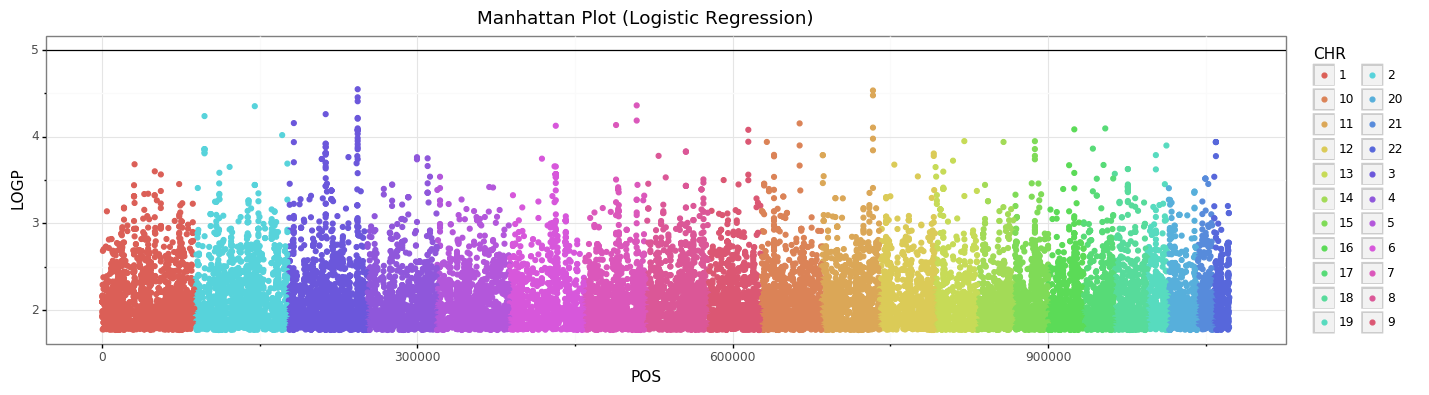

<ggplot: (8778900934353)>

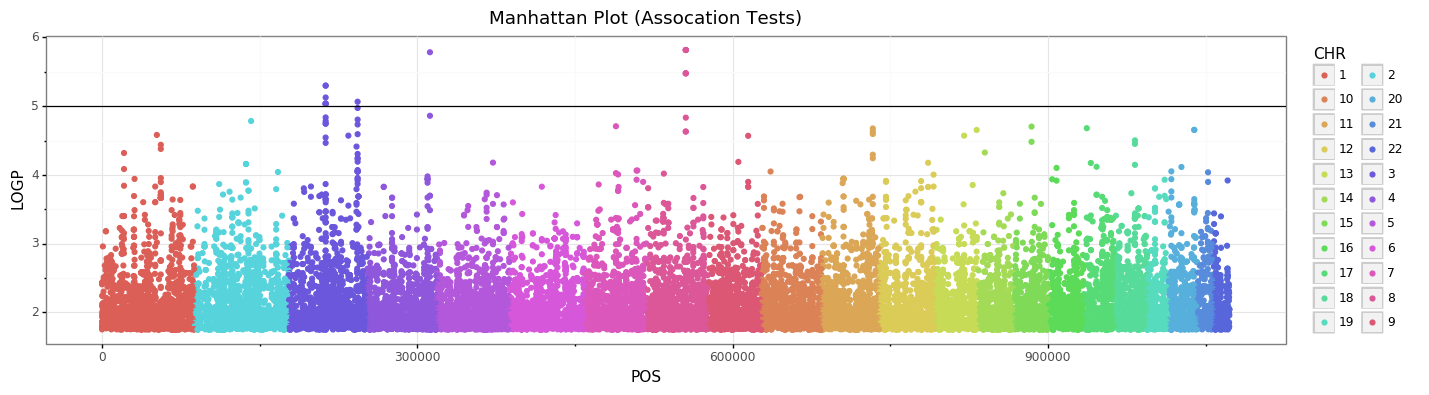

<ggplot: (8778901958105)>

In [122]:
display(manhattan_plot(get_data(osp.join(data_dir, 'logistic_results.assoc_2.logistic'))) + 
        pn.ggtitle('Manhattan Plot (Logistic Regression)'))
display(manhattan_plot(get_data(osp.join(data_dir, 'assoc_results.assoc'))) + 
        pn.ggtitle('Manhattan Plot (Assocation Tests)'))

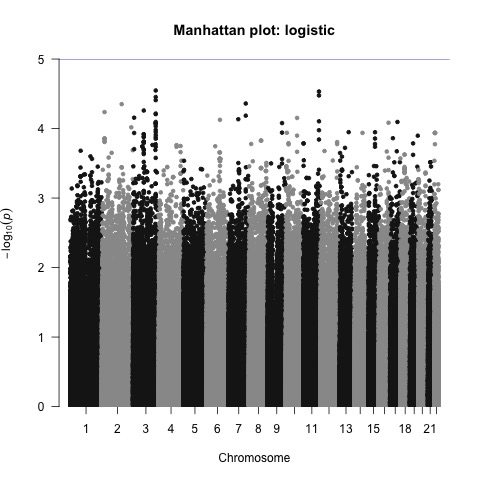

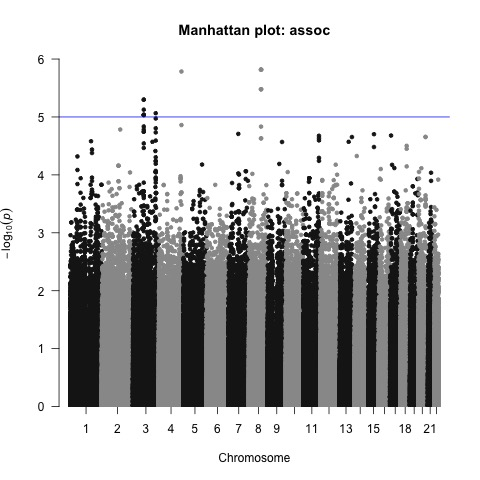

In [123]:
display(Image('figures/manhattan-logistic.jpeg'))
display(Image('figures/manhattan-assoc.jpeg'))

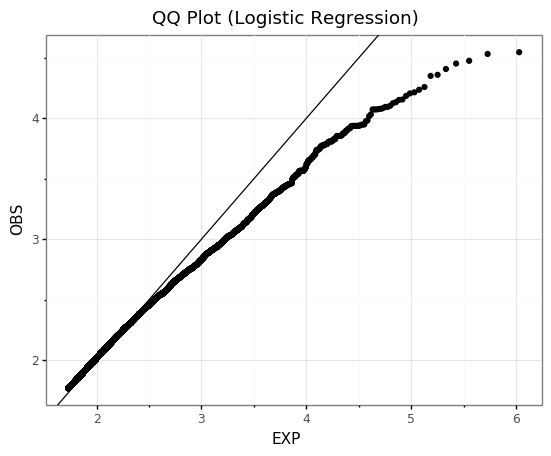

<ggplot: (8778901190977)>

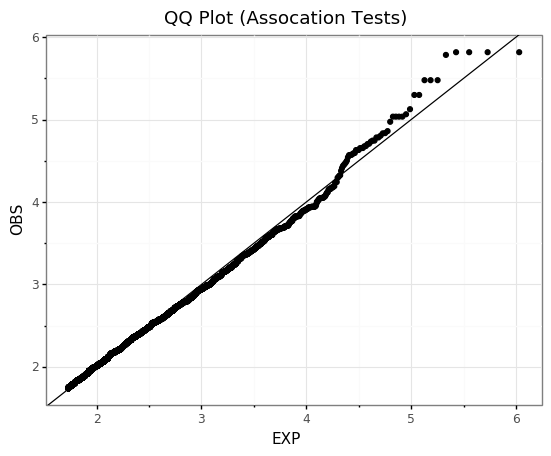

<ggplot: (8778901942761)>

In [114]:
display(qq_plot(get_data(osp.join(data_dir, 'logistic_results.assoc_2.logistic'))) + 
        pn.ggtitle('QQ Plot (Logistic Regression)'))
display(qq_plot(get_data(osp.join(data_dir, 'assoc_results.assoc'))) + 
        pn.ggtitle('QQ Plot (Assocation Tests)'))

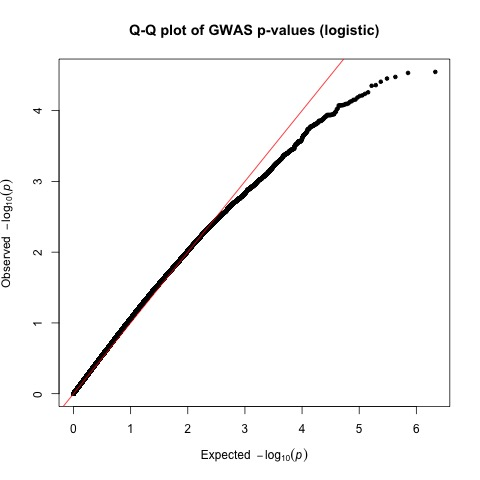

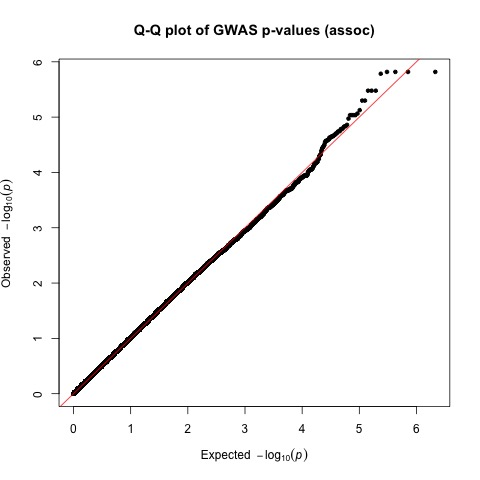

In [124]:
display(Image('figures/QQ-Plot_logistic.jpeg'))
display(Image('figures/QQ-Plot_assoc.jpeg'))